In [4]:
import re

def read_kurucz_model(file_path):
    """
    Reads a Kurucz stellar atmospheric model grid file and returns a dictionary with parsed data.
    Extracts [Fe/H] and [α/Fe] values from the filename.
    
    Parameters:
    file_path (str): Path to the Kurucz model file.
    
    Returns:
    dict: A dictionary containing the parsed header, abundance data, and atmospheric structure.
    """
    # Parse [Fe/H] and [α/Fe] from filename
    filename = file_path.split('/')[-1]
    
    # More robust regex patterns for metal content values
    feh_pattern = r'feh([+-]?\d+\.?\d*)'
    afe_pattern = r'afe([+-]?\d+\.?\d*)'
    
    feh_match = re.search(feh_pattern, filename)
    afe_match = re.search(afe_pattern, filename)
    
    feh = float(feh_match.group(1)) if feh_match else None
    afe = float(afe_match.group(1)) if afe_match else None
    
    model = {
        'teff': None,
        'gravity': None,
        'title': None,
        'feh': feh,  # Add [Fe/H] from filename
        'afe': afe,  # Add [α/Fe] from filename
        'filename': filename,
        'opacity_ifop': [],
        'convection': {'status': 'OFF', 'parameters': []},
        'turbulence': {'status': 'OFF', 'parameters': []},
        'abundance_scale': None,
        'abundance_changes': {},
        # Directly index the columns we're interested in
        'RHOX': [],
        'T': [],
        'P': [],
        'XNE': [],
        'ABROSS': [],
        'ACCRAD': [],
        'VTURB': [],
        # Store original data columns for reference
        'data_columns': []
    }

    with open(file_path, 'r') as f:
        # Read lines until TEFF line is found
        line = ''
        while True:
            line = f.readline()
            if not line:
                break
            if line.startswith('TEFF'):
                break
        
        # Parse TEFF and GRAVITY
        parts = line.split()
        model['teff'] = float(parts[1])
        model['gravity'] = float(parts[3].strip())
        
        # Read TITLE
        line = f.readline().strip()
        model['title'] = line.split('TITLE')[1].strip() if 'TITLE' in line else line
        
        # Parse OPACITY line
        line = f.readline().strip()
        parts = line.split()
        model['opacity_ifop'] = list(map(int, parts[2:22]))  # 20 opacity flags
        
        # Parse CONVECTION and TURBULENCE line
        line = f.readline().strip()
        parts = line.split()
        conv_idx = parts.index('CONVECTION')
        turb_idx = parts.index('TURBULENCE')
        
        model['convection']['status'] = parts[conv_idx + 1]
        model['convection']['parameters'] = list(map(float, parts[conv_idx + 2:turb_idx]))
        
        model['turbulence']['status'] = parts[turb_idx + 1]
        model['turbulence']['parameters'] = list(map(float, parts[turb_idx + 2:]))
        
        # Parse ABUNDANCE SCALE
        line = f.readline().strip()
        parts = line.split()
        model['abundance_scale'] = float(parts[2])
        
        # Parse ABUNDANCE CHANGE lines
        line = f.readline().strip()
        while line.startswith('ABUNDANCE CHANGE'):
            parts = line.split()
            for i in range(2, len(parts), 2):
                elem_num = int(parts[i])
                abundance = float(parts[i+1])
                model['abundance_changes'][elem_num] = abundance
            line = f.readline().strip()
        
        # Skip until READ DECK6 line
        while not line.startswith('READ DECK6'):
            line = f.readline().strip()
        
        # Parse READ DECK6 parameters
        parts = line.split()
        num_depth_points = int(parts[2])
        model['data_columns'] = parts[3:]  # Expected columns
        
        # Define the target columns we're interested in
        target_columns = ['RHOX', 'T', 'P', 'XNE', 'ABROSS', 'ACCRAD', 'VTURB']
        
        # The READ DECK6 line specifies 7 columns, but 
        # the data rows might contain additional values (extra columns)
        
        # Read atmospheric structure data
        for _ in range(num_depth_points):
            line = f.readline()
            values = list(map(float, line.strip().split()))
            
            # The first 7 values correspond to RHOX,T,P,XNE,ABROSS,ACCRAD,VTURB
            # regardless of how many extra columns there are
            if len(values) >= 7:
                model['RHOX'].append(values[0])
                model['T'].append(values[1])
                model['P'].append(values[2])
                model['XNE'].append(values[3])
                model['ABROSS'].append(values[4])
                model['ACCRAD'].append(values[5])
                model['VTURB'].append(values[6])
                
                # Store any extra columns as a list
                if len(values) > 7:
                    if 'extra_columns' not in model:
                        model['extra_columns'] = []
                    model['extra_columns'].append(values[7:])
    
    return model

# Test with the provided paste.txt file
# model_data = read_kurucz_model('/Users/jdli/Project/kurucz1/data/C3K_atmosphere/atm_vturb=0.5/at12_feh-0.25_afe-0.2_t02500g-1.0.atm')
import glob


fnames = glob.glob('/Users/jdli/Project/kurucz1/data/C3K_atmosphere/atm_vturb=1.5/*.atm')

idx = np.random.randint(0, len(fnames))

# Example usage
model_data = read_kurucz_model(fnames[idx])
# model_data = read_kurucz_model('/Users/jdli/Project/kurucz1/data/C3K_atmosphere/atm_vturb=1.5/at12_feh-0.25_afe-0.2_t06000g5.00.atm')
print(f"Effective Temperature (TEFF): {model_data['teff']} K")
print(f"Surface Gravity (log g): {model_data['gravity']}")
print(f"[Fe/H]: {model_data.get('feh', 'Not found in filename')}")
print(f"[α/Fe]: {model_data.get('afe', 'Not found in filename')}")
print(f"Number of data points: {len(model_data['RHOX'])}")

# Print first few rows of the atmospheric structure
for i in range(3):
    print(f"Layer {i+1}:", {
        'RHOX': model_data['RHOX'][i],
        'T': model_data['T'][i], 
        'P': model_data['P'][i],
        'XNE': model_data['XNE'][i],
        'ABROSS': model_data['ABROSS'][i],
        'ACCRAD': model_data['ACCRAD'][i],
        'VTURB': model_data['VTURB'][i]
    })
    
    # Show any extra columns if present
    if 'extra_columns' in model_data and model_data['extra_columns']:
        print(f"  Extra columns: {model_data['extra_columns'][i]}")

Effective Temperature (TEFF): 3500.0 K
Surface Gravity (log g): 2.5
[Fe/H]: -0.75
[α/Fe]: 0.6
Number of data points: 80
Layer 1: {'RHOX': 0.00275764039, 'T': 2320.6, 'P': 0.872, 'XNE': 5545000.0, 'ABROSS': 4.836e-05, 'ACCRAD': 0.003083, 'VTURB': 150000.0}
  Extra columns: [0.0, 0.0]
Layer 2: {'RHOX': 0.00361274863, 'T': 2337.4, 'P': 1.142, 'XNE': 7201000.0, 'ABROSS': 5.566e-05, 'ACCRAD': 0.003107, 'VTURB': 150000.0}
  Extra columns: [0.0, 0.0]
Layer 3: {'RHOX': 0.00460426842, 'T': 2351.8, 'P': 1.456, 'XNE': 9091000.0, 'ABROSS': 6.399e-05, 'ACCRAD': 0.003138, 'VTURB': 150000.0}
  Extra columns: [0.0, 0.0]


In [13]:
import numpy as np

def compute_tau(RHOX, ABROSS):
    """
    Compute the optical depth (tau) from the column mass (RHOX) 
    and the Rosseland mean opacity (ABROSS) using trapezoidal integration.
    
    Parameters:
        RHOX (numpy.ndarray): Array of column mass values.
        ABROSS (numpy.ndarray): Array of opacity values.
    
    Returns:
        numpy.ndarray: Cumulative optical depth (tau) computed from the data.
    """
    # Ensure the arrays are numpy arrays and have the same length
    RHOX = np.asarray(RHOX)
    ABROSS = np.asarray(ABROSS)
    
    # Initialize the tau array; tau[0] is typically set to 0 at the top of the atmosphere
    tau = np.zeros_like(RHOX)
    
    # Use a cumulative trapezoidal integration to compute tau
    # tau[i] = tau[i-1] + 0.5 * (ABROSS[i] + ABROSS[i-1]) * (RHOX[i] - RHOX[i-1])
    for i in range(1, len(RHOX)):
        dRHOX = RHOX[i] - RHOX[i-1]
        tau[i] = tau[i-1] + 0.5 * (ABROSS[i] + ABROSS[i-1]) * dRHOX
    
    return tau

tau = compute_tau(model_data['RHOX'], model_data['ABROSS'])
print(f"Optical depth at the surface: {tau[0]}")

Optical depth at the surface: 0.0


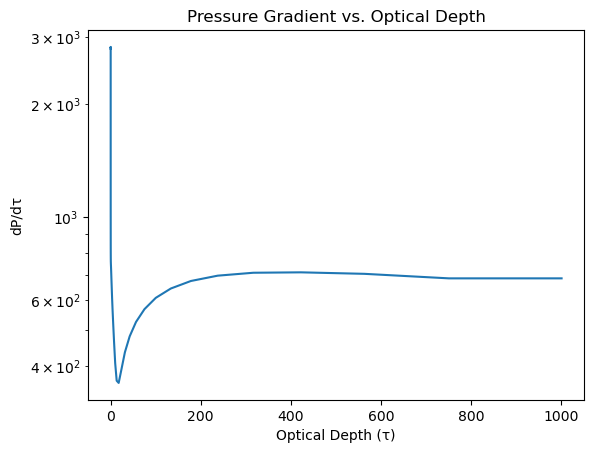

In [14]:
from matplotlib import pyplot as plt

def calculate_gradient_numpy(x, y):
    """
    Calculate the differential gradient (dy/dx) for given x and y arrays using NumPy.
    
    Parameters:
        x (numpy.ndarray): Independent variable
        y (numpy.ndarray): Dependent variable
        
    Returns:
        numpy.ndarray: Gradient dy/dx with same shape as input
    """
    import numpy as np
    
    # Convert inputs to numpy arrays if they aren't already
    if not isinstance(x, np.ndarray):
        x = np.array(x, dtype=np.float32)
    if not isinstance(y, np.ndarray):
        y = np.array(y, dtype=np.float32)
    
    # Ensure x and y have the same shape
    if x.shape != y.shape:
        raise ValueError(f"x and y must have the same shape. Got x: {x.shape}, y: {y.shape}")
    
    # Calculate the differences (forward difference)
    dx = np.diff(x, axis=-1)
    dy = np.diff(y, axis=-1)
    
    # Calculate the gradient dy/dx
    gradient = dy / (dx + 1e-10)  # Add small epsilon to avoid division by zero
    
    # For the last point, use the last calculated gradient
    # This pads the gradient array to match the input shape
    if len(x.shape) == 1:
        gradient = np.concatenate([gradient, gradient[-1:]])
    else:
        # For batched data, pad along the appropriate dimension
        gradient = np.concatenate([gradient, gradient[:, -1:]], axis=1)
    
    return gradient

# Example usage:
dP_dtau = calculate_gradient_numpy(tau, model_data['P'])
plt.plot(tau, dP_dtau)
plt.xlabel('Optical Depth (τ)')
plt.ylabel('dP/dτ')
plt.title('Pressure Gradient vs. Optical Depth')
plt.yscale('log')

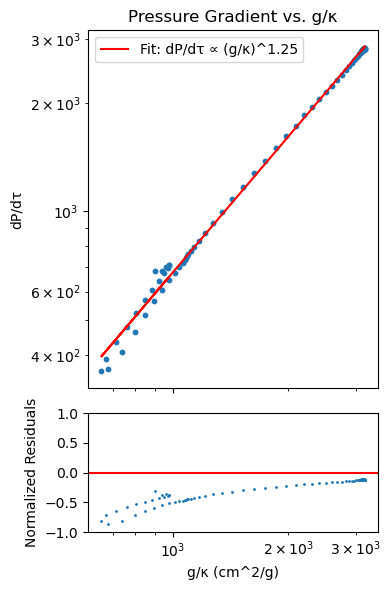

In [15]:
g = np.power(10., model_data['gravity']) # cm/s^2
g_kappa = g / model_data['ABROSS'] 

# Create a figure with two subplots (main plot and residual plot)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

# Main plot (top)
ax1.scatter(g_kappa, dP_dtau, s=10)
ax1.set_ylabel('dP/dτ')
ax1.set_title('Pressure Gradient vs. g/κ')
ax1.set_yscale('log')
ax1.set_xscale('log')

# Fit a power law to the data (log-log linear fit)
log_g_kappa = np.log10(g_kappa)
log_dP_dtau = np.log10(dP_dtau)
mask = ~np.isnan(log_g_kappa) & ~np.isnan(log_dP_dtau) & ~np.isinf(log_g_kappa) & ~np.isinf(log_dP_dtau)
slope, intercept = np.polyfit(log_g_kappa[mask], log_dP_dtau[mask], 1)
fit_line = 10**(slope * log_g_kappa + intercept)

# Add the fit line to the main plot
ax1.plot(g_kappa, fit_line, 'r-', label=f'Fit: dP/dτ ∝ (g/κ)^{slope:.2f}')
ax1.legend()

# Residual plot (bottom)
residuals = dP_dtau - g_kappa
ax2.scatter(g_kappa, residuals/dP_dtau, s=1)  # Normalized residuals
ax2.axhline(y=0, color='r', linestyle='-')
ax2.set_ylabel('Normalized Residuals')
ax2.set_xlabel('g/κ (cm^2/g)')
ax2.set_ylim(-1, 1)  # Adjust as needed

plt.tight_layout()

# Normalization Strategies

After analyzing the provided code, I've extracted the normalization strategies applied to each parameter in the Kurucz atmospheric models. The dataset implementation uses a systematic approach for normalization with parameter-specific strategies.

## General Normalization Pattern

The code uses a two-step normalization process:
1. Apply log transformation for certain parameters (when appropriate)
2. Apply min-max scaling to map values to the [-1, 1] range

## Parameter-Specific Normalization

### Input Parameters:
- **teff** (Effective Temperature):
  - Log transformation (log10) is applied first
  - Then min-max scaling to [-1, 1] range
  - This handles the large numerical range of temperature values

- **gravity** (Surface Gravity):
  - Direct min-max scaling to [-1, 1] range
  - No log transformation (already in log scale as log g)

- **feh** ([Fe/H] - Metallicity):
  - Direct min-max scaling to [-1, 1] range
  - No log transformation (already on a logarithmic scale)

- **afe** ([α/Fe] - Alpha Enhancement):
  - Direct min-max scaling to [-1, 1] range
  - No log transformation

### Atmospheric Structure Parameters:
- **RHOX** (Mass Column Density):
  - Log transformation (log10)
  - Min-max scaling to [-1, 1] range

- **T** (Temperature):
  - Direct min-max scaling to [-1, 1] range
  - No log transformation

- **P** (Pressure):
  - Log transformation (log10)
  - Min-max scaling to [-1, 1] range

- **XNE** (Electron Number Density):
  - Log transformation (log10)
  - Min-max scaling to [-1, 1] range

- **ABROSS** (Rosseland Mean Opacity):
  - Log transformation (log10)
  - Min-max scaling to [-1, 1] range

- **ACCRAD** (Radiative Acceleration):
  - Log transformation (log10)
  - Min-max scaling to [-1, 1] range

- **TAU** (Optical Depth):
  - Log transformation (log10)
  - Min-max scaling to [-1, 1] range

## Implementation Details

A small epsilon value (1e-30) is added to parameters before applying log transformation to avoid log(0) issues. For each parameter, normalization information is stored in the `norm_params` dictionary with entries containing:
- `min`: Minimum value (after log transform if applicable)
- `max`: Maximum value (after log transform if applicable) 
- `log_scale`: Boolean flag indicating whether log transformation is applied

The code also includes denormalization functionality to convert the normalized values back to their original physical units when needed for interpretation or visualization.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
import glob
import numpy as np
import re

class KuruczDataset(Dataset):
    """
    Dataset for Kurucz stellar atmosphere models with standardized [-1, 1] normalization.
    """
    def __init__(self, data_dir, file_pattern='*.atm', max_depth_points=80, device='cpu'):
        self.data_dir = data_dir
        self.file_paths = glob.glob(os.path.join(data_dir, file_pattern))
        self.max_depth_points = max_depth_points
        self.device = device
        self.norm_params = {}
        
        # Load and process all files
        self.models = []
        for file_path in self.file_paths:
            try:
                model = read_kurucz_model(file_path)
                # Calculate optical depth (tau) for each model
                self.calculate_tau(model)
                self.models.append(model)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
        
        if len(self.models) == 0:
            raise ValueError(f"No valid model files found in {data_dir} with pattern {file_pattern}")
        
        # Extract input and output features
        self.prepare_data()
        
        # Calculate normalization parameters
        self.setup_normalization()
        
        # Apply normalization to all data
        self.normalize_all_data()

    def calculate_tau(self, model):
        """
        Calculate optical depth (tau) for a model by integrating opacity over mass column density.
        
        Parameters:
            model (dict): The model dictionary containing RHOX and ABROSS arrays
            
        Returns:
            None: Adds 'TAU' key to the model dictionary
        """
        # Get the mass column density (RHOX) and opacity (ABROSS)
        rhox = np.array(model['RHOX'])
        abross = np.array(model['ABROSS'])
        
        # Initialize tau array
        tau = np.zeros_like(rhox)
        
        # The Kurucz models are typically ordered from the outer atmosphere (low density)
        # to the inner atmosphere (high density), so we integrate from outside in
        for i in range(1, len(rhox)):
            # Calculate the increment in tau using the trapezoidal rule
            delta_rhox = rhox[i] - rhox[i-1]
            avg_opacity = (abross[i] + abross[i-1]) / 2.0
            delta_tau = avg_opacity * delta_rhox
            
            # Add to the cumulative tau
            tau[i] = tau[i-1] + delta_tau
        
        # Store tau in the model
        model['TAU'] = tau.tolist()
        
        return None

    def prepare_data(self):
        """Prepare data tensors from the loaded models"""
        # Input features: teff, gravity, feh, afe
        self.teff_list = []
        self.gravity_list = []
        self.feh_list = []
        self.afe_list = []
        
        # Output features: RHOX, T, P, XNE, ABROSS, ACCRAD, TAU
        self.rhox_list = []
        self.t_list = []
        self.p_list = []
        self.xne_list = []
        self.abross_list = []
        self.accrad_list = []
        self.tau_list = []  # Add tau list
        
        # Process each model
        for model in self.models:
            # Pad or truncate depth profiles to max_depth_points
            rhox = self.pad_sequence(model['RHOX'], self.max_depth_points)
            t = self.pad_sequence(model['T'], self.max_depth_points)
            p = self.pad_sequence(model['P'], self.max_depth_points)
            xne = self.pad_sequence(model['XNE'], self.max_depth_points)
            abross = self.pad_sequence(model['ABROSS'], self.max_depth_points)
            accrad = self.pad_sequence(model['ACCRAD'], self.max_depth_points)
            tau = self.pad_sequence(model['TAU'], self.max_depth_points)  # Add tau
            
            # Store input parameters
            self.teff_list.append(model['teff'])
            self.gravity_list.append(model['gravity'])
            self.feh_list.append(model['feh'] if model['feh'] is not None else 0.0)
            self.afe_list.append(model['afe'] if model['afe'] is not None else 0.0)
            
            # Store output parameters
            self.rhox_list.append(rhox)
            self.t_list.append(t)
            self.p_list.append(p)
            self.xne_list.append(xne)
            self.abross_list.append(abross)
            self.accrad_list.append(accrad)
            self.tau_list.append(tau)  # Add tau
        
        # Convert to tensors
        self.original = {
            'teff': torch.tensor(self.teff_list, dtype=torch.float32, device=self.device).unsqueeze(1),
            'gravity': torch.tensor(self.gravity_list, dtype=torch.float32, device=self.device).unsqueeze(1),
            'feh': torch.tensor(self.feh_list, dtype=torch.float32, device=self.device).unsqueeze(1),
            'afe': torch.tensor(self.afe_list, dtype=torch.float32, device=self.device).unsqueeze(1),
            'RHOX': torch.tensor(self.rhox_list, dtype=torch.float32, device=self.device),
            'T': torch.tensor(self.t_list, dtype=torch.float32, device=self.device),
            'P': torch.tensor(self.p_list, dtype=torch.float32, device=self.device),
            'XNE': torch.tensor(self.xne_list, dtype=torch.float32, device=self.device),
            'ABROSS': torch.tensor(self.abross_list, dtype=torch.float32, device=self.device),
            'ACCRAD': torch.tensor(self.accrad_list, dtype=torch.float32, device=self.device),
            'TAU': torch.tensor(self.tau_list, dtype=torch.float32, device=self.device)  # Add tau
        }

    def setup_normalization(self):
        """Calculate normalization parameters for each feature"""
        log_params = ['teff', 'RHOX', 'P', 'XNE', 'ABROSS', 'ACCRAD', 'TAU']
        
        for param_name, data in self.original.items():
            if param_name in log_params:
                transformed_data = torch.log10(data + 1e-30)
                log_scale = True
            else:
                transformed_data = data
                log_scale = False
            
            # 新增 scale 计算
            if transformed_data.dim() > 2:
                param_min = transformed_data.min(dim=0).values
                param_max = transformed_data.max(dim=0).values
            else:
                param_min = transformed_data.min()
                param_max = transformed_data.max()
            
            # 显式存储 scale = (max - min)/2
            self.norm_params[param_name] = {
                'min': param_min,
                'max': param_max,
                'scale': (param_max - param_min) / 2.0,  # 新增关键字段
                'log_scale': log_scale
            }
            
    def normalize_all_data(self):
        """Apply normalization to all data tensors"""
        # Normalize input parameters
        self.teff = self.normalize('teff', self.original['teff'])
        self.gravity = self.normalize('gravity', self.original['gravity'])
        self.feh = self.normalize('feh', self.original['feh'])
        self.afe = self.normalize('afe', self.original['afe'])
        
        # Normalize output parameters
        self.RHOX = self.normalize('RHOX', self.original['RHOX'])
        self.T = self.normalize('T', self.original['T'])
        self.P = self.normalize('P', self.original['P'])
        self.XNE = self.normalize('XNE', self.original['XNE'])
        self.ABROSS = self.normalize('ABROSS', self.original['ABROSS'])
        self.ACCRAD = self.normalize('ACCRAD', self.original['ACCRAD'])
        self.TAU = self.normalize('TAU', self.original['TAU'])  # Add TAU normalization

    def normalize(self, param_name, data):
        """
        Normalize data to [-1, 1] range with optional log transform.

        Parameters:
            param_name (str): Name of the parameter to normalize
            data (torch.Tensor): Data to normalize

        Returns:
            torch.Tensor: Normalized data in [-1, 1] range
        """
        params = self.norm_params[param_name]
        
        # Apply log transform if needed
        if params['log_scale']:
            transformed_data = torch.log10(data + 1e-30)
        else:
            transformed_data = data
        
        # Apply min-max scaling to [-1, 1] range
        normalized = 2.0 * (transformed_data - params['min']) / (params['max'] - params['min']) - 1.0
        
        return normalized

    def denormalize(self, param_name, normalized_data):
        """
        Denormalize data from [-1, 1] range back to original scale.

        Parameters:
            param_name (str): Name of the parameter to denormalize
            normalized_data (torch.Tensor): Normalized data to convert back

        Returns:
            torch.Tensor: Denormalized data with gradients preserved
        """
        params = self.norm_params[param_name]
        
        # Reverse min-max scaling from [-1, 1] range
        transformed_data = (normalized_data + 1.0) / 2.0 * (params['max'] - params['min']) + params['min']
        
        # Reverse log transform if needed
        if params['log_scale']:
            denormalized_data = torch.pow(10.0, transformed_data) - 1e-30
        else:
            denormalized_data = transformed_data
        
        # Ensure gradient propagation is maintained and data stays on the correct device
        return denormalized_data.to(self.device)

    def pad_sequence(self, values, target_length):
        """Pad a sequence to the target length"""
        if len(values) >= target_length:
            return values[:target_length]
        
        # Pad with the last value
        padding_needed = target_length - len(values)
        return values + [values[-1]] * padding_needed
    
    def __len__(self):
        return len(self.teff)
    
    def __getitem__(self, idx):
        """Return normalized input features and output features"""
        # Get the normalized tau for this model
        tau_features = self.TAU[idx]
        
        # Create stellar parameter features (already normalized)
        stellar_params = torch.cat([
            self.teff[idx],
            self.gravity[idx],
            self.feh[idx],
            self.afe[idx]
        ], dim=0)
        
        # Input features: stellar parameters and tau at each depth point
        # For each depth point, we'll have [teff, gravity, feh, afe, tau]
        # Expand stellar parameters to match the depth dimension
        batch_size = 1 if stellar_params.dim() == 1 else stellar_params.shape[0]
        depth_points = tau_features.shape[0]
        
        # Reshape stellar parameters to [batch, 1, params] and expand to [batch, depth, params]
        expanded_params = stellar_params.unsqueeze(1).expand(-1, depth_points, -1) if batch_size > 1 else \
                          stellar_params.unsqueeze(0).expand(depth_points, -1)
        
        # Add tau as an additional input feature [batch, depth, params+1]
        tau_reshaped = tau_features.unsqueeze(-1) if tau_features.dim() == 1 else tau_features
        
        # Combine stellar parameters with tau
        input_features = torch.cat([expanded_params, tau_reshaped], dim=-1)
        
        # Output features (already normalized) - now without TAU
        output_features = torch.stack([
            self.RHOX[idx],
            self.T[idx],
            self.P[idx],
            self.XNE[idx],
            self.ABROSS[idx],
            self.ACCRAD[idx]
        ], dim=1)
        
        return input_features, output_features
    
    def inverse_transform_inputs(self, inputs):
        """Transform normalized inputs back to physical units"""
        if inputs.dim() == 1:
            inputs = inputs.unsqueeze(0)  # Add batch dimension if needed
            
        # Split the input tensor back into individual parameters
        teff = inputs[:, 0:1]
        gravity = inputs[:, 1:2]
        feh = inputs[:, 2:3]
        afe = inputs[:, 3:4]
        
        # Denormalize each parameter
        teff_denorm = self.denormalize('teff', teff)
        gravity_denorm = self.denormalize('gravity', gravity)
        feh_denorm = self.denormalize('feh', feh)
        afe_denorm = self.denormalize('afe', afe)
        
        # Return as a dictionary for clarity
        return {
            'teff': teff_denorm,
            'gravity': gravity_denorm,
            'feh': feh_denorm,
            'afe': afe_denorm
        }
    
    def inverse_transform_outputs(self, outputs):
        """Transform normalized outputs back to physical units"""
        batch_size, depth_points, num_features = outputs.shape
        
        # Initialize containers for denormalized data
        columns = ['RHOX', 'T', 'P', 'XNE', 'ABROSS', 'ACCRAD', 'TAU']  # Add TAU
        result = {param: None for param in columns}
        
        # Denormalize each feature
        for i, param_name in enumerate(columns):
            # Extract the i-th feature for all samples and depths
            feature_data = outputs[:, :, i]
            # Denormalize
            result[param_name] = self.denormalize(param_name, feature_data)
        
        return result
    
    def save_dataset(self, filepath):
        """
        Save the dataset, including all normalized data and normalization parameters.
        
        Parameters:
            filepath (str): Path to save the dataset
        """
        # Create a dictionary with all necessary data
        save_dict = {
            'norm_params': self.norm_params,
            'max_depth_points': self.max_depth_points,
            'data': {
                # Input features
                'teff': self.teff,
                'gravity': self.gravity,
                'feh': self.feh,
                'afe': self.afe,
                # Output features
                'RHOX': self.RHOX,
                'T': self.T,
                'P': self.P,
                'XNE': self.XNE,
                'ABROSS': self.ABROSS,
                'ACCRAD': self.ACCRAD,
                'TAU': self.TAU,  # Add TAU
                # Original data (optional, can be commented out to save space)
                'original': self.original
            }
        }
        
        # Save to file
        torch.save(save_dict, filepath)
        print(f"Dataset saved to {filepath}")

    @classmethod
    def load_dataset(cls, filepath, device='cpu'):
        """
        Load a saved dataset.
        
        Parameters:
            filepath (str): Path to the saved dataset
            device (str): Device to load the data to ('cpu' or 'cuda')
            
        Returns:
            KuruczDataset: Loaded dataset
        """
        # Create an empty dataset
        dataset = cls.__new__(cls)
        
        # Load the saved data
        save_dict = torch.load(filepath, map_location=device)
        
        # Restore attributes
        dataset.norm_params = save_dict['norm_params']
        dataset.max_depth_points = save_dict['max_depth_points']
        dataset.device = device
        
        # Move data to the specified device
        for key, tensor in save_dict['data'].items():
            if isinstance(tensor, dict):
                # Handle nested dictionaries (like 'original')
                setattr(dataset, key, {k: v.to(device) for k, v in tensor.items()})
            else:
                setattr(dataset, key, tensor.to(device))
        
        # Initialize empty models list (not needed after loading)
        dataset.models = []
        
        return dataset


def create_dataloader(data_dir, batch_size=32, num_workers=4, file_pattern='*.atm', 
                     max_depth_points=80, device='cpu'):
    """
    Create DataLoader for Kurucz atmospheric models.
    
    Parameters:
    data_dir (str): Directory containing the model files
    batch_size (int): Batch size for the DataLoader
    num_workers (int): Number of worker processes for the DataLoader
    file_pattern (str): Pattern to match model files
    max_depth_points (int): Maximum number of depth points to use (for padding)
    device (str): Device to use for tensor operations
    
    Returns:
    tuple: (DataLoader, Dataset) for the Kurucz models
    """
    dataset = KuruczDataset(data_dir, file_pattern, max_depth_points, device)
    
    # Create DataLoader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True if device=='cuda' else False,
    )
    
    return dataloader, dataset


In [5]:
data_dir = "/Users/jdli/Project/kurucz1/data/C3K_atmosphere/atm_vturb=0.5/"

dataset = KuruczDataset(
    data_dir=data_dir,
    file_pattern="*.atm",
    max_depth_points=80,
    device=torch.device("cpu"),
)

Error loading /Users/jdli/Project/kurucz1/data/C3K_atmosphere/atm_vturb=0.5/at12_feh-1.00_afe+0.6_t05000g0.00.atm: could not convert string to float: '1.362E+14-3.951E+00'


In [6]:
# 2. Get the dataset size
num_models = len(dataset)
print(f"Dataset contains {num_models} stellar atmosphere models")


Dataset contains 42696 stellar atmosphere models


In [7]:
# 3. Access a single data point (normalized)
inputs, outputs = dataset[0]
print(f"Input shape: {inputs.shape}")  # [4] (teff, gravity, feh, afe)
print(f"Output shape: {outputs.shape}")  # [max_depth_points, 6]

# 4. Create a DataLoader
dataloader, _ = create_dataloader(
    data_dir=data_dir,
    batch_size=32,
    num_workers=4
)

Input shape: torch.Size([80, 5])
Output shape: torch.Size([80, 6])
Error loading /Users/jdli/Project/kurucz1/data/C3K_atmosphere/atm_vturb=0.5/at12_feh-1.00_afe+0.6_t05000g0.00.atm: could not convert string to float: '1.362E+14-3.951E+00'


In [8]:
dataset.save_dataset("/Users/jdli/Project/kurucz1/data/kurucz_vturb_0p5_tau_v2.pt")


Dataset saved to /Users/jdli/Project/kurucz1/data/kurucz_vturb_0p5_tau_v2.pt


In [9]:
def print_dataset_ranges(dataset):
    """Print min, max, mean and std for all tensors in the dataset"""
    print("\n=== Dataset Value Ranges ===")

    # Track all attributes that are tensors
    for attr_name in dir(dataset):
        if attr_name.startswith('__') or callable(getattr(dataset, attr_name)):
            continue

        attr = getattr(dataset, attr_name)

        if isinstance(attr, torch.Tensor):
            min_val = attr.min().item()
            max_val = attr.max().item()
            mean_val = attr.mean().item()
            std_val = attr.std().item()
            print(f"{attr_name:10s}: min={min_val:.6e}, max={max_val:.6e}, mean={mean_val:.6e}, std={std_val:.6e}")

        # Check if it's the 'original' dictionary with the raw data
        elif attr_name == 'original' and isinstance(attr, dict):
            print("\n--- Original (Raw) Data ---")
            for k, v in attr.items():
                if isinstance(v, torch.Tensor):
                    min_val = v.min().item()
                    max_val = v.max().item()
                    mean_val = v.mean().item()
                    std_val = v.std().item()
                    print(f"{k:10s}: min={min_val:.6e}, max={max_val:.6e}, mean={mean_val:.6e}, std={std_val:.6e}")

    # Also print normalization parameters if available
    if hasattr(dataset, 'norm_params'):
        print("\n--- Normalization Parameters ---")
        for param, values in dataset.norm_params.items():
            print(f"{param}: {values}")

# Call this after creating your dataset
print_dataset_ranges(dataset)



=== Dataset Value Ranges ===
ABROSS    : min=-1.000000e+00, max=1.000000e+00, mean=2.310525e-01, std=3.447032e-01
ACCRAD    : min=-1.000000e+00, max=1.000000e+00, mean=7.411157e-01, std=1.379601e-01
P         : min=-1.000000e+00, max=1.000000e+00, mean=1.005999e-01, std=3.102574e-01
RHOX      : min=-1.000000e+00, max=1.000000e+00, mean=-9.278245e-02, std=3.880101e-01
T         : min=-1.000000e+00, max=1.000000e+00, mean=-9.080770e-01, std=1.440797e-01
TAU       : min=-1.000000e+00, max=1.000000e+00, mean=6.718833e-01, std=2.543701e-01
XNE       : min=-1.000000e+00, max=1.000000e+00, mean=3.251018e-01, std=3.206106e-01
afe       : min=-1.000000e+00, max=1.000000e+00, mean=-2.728593e-02, std=6.969092e-01
feh       : min=-1.000000e+00, max=1.000000e+00, mean=-6.138536e-02, std=4.941292e-01
gravity   : min=-1.000000e+00, max=1.000000e+00, mean=3.000137e-01, std=4.672782e-01

--- Original (Raw) Data ---
teff      : min=2.500000e+03, max=5.000000e+04, mean=1.177300e+04, std=9.853889e+03
gra

# test

In [53]:
dataset_path = "/Users/jdli/Project/kurucz1/data/kurucz_vturb_0p5_tau.pt"

hidden_size = 32
device = torch.device('cpu')


%reload_ext autoreload
%autoreload 2
from train import load_dataset_file
# Load dataset and model
x = load_dataset_file(dataset_path, device)

In [57]:
class AtmosphereNet(torch.nn.Module):
    def __init__(self, input_size=5, hidden_size=256, output_size=6, depth_points=80):
        super(AtmosphereNet, self).__init__()
        self.input_size = input_size  # Now includes tau (teff, gravity, feh, afe, tau)
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.depth_points = depth_points
        
        # Shared feature extractor for each depth point
        self.feature_extractor = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1)
        )
        
        # Final prediction layers
        self.output_layers = torch.nn.Sequential(
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            
            torch.nn.Linear(hidden_size, output_size)
        )
        
    def forward(self, x):
        # Input shape: (batch_size, depth_points, input_size)
        batch_size, depth_points, _ = x.shape
        
        # Process each depth point independently
        # Reshape to (batch_size * depth_points, input_size)
        x_reshaped = x.reshape(-1, self.input_size)
        
        # Extract features for each depth point
        features = self.feature_extractor(x_reshaped)
        
        # Generate predictions for each depth point
        outputs = self.output_layers(features)
        
        # Reshape back to (batch_size, depth_points, output_size)
        outputs = outputs.view(batch_size, depth_points, self.output_size)
        
        return outputs

test_model = AtmosphereNet()
test_model

AtmosphereNet(
  (feature_extractor): Sequential(
    (0): Linear(in_features=5, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
  )
  (output_layers): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=6, bias=True)
  )
)

In [62]:
test_model(dataset[0][0].reshape(1, 80, 5))

tensor([[[ 1.2387e-02, -5.8478e-02, -4.4194e-02,  2.8015e-02,  6.1278e-02,
           7.4038e-02],
         [ 3.4559e-02, -1.1279e-01, -4.5882e-02,  2.3603e-02,  2.7637e-02,
           6.2800e-02],
         [ 2.4251e-02, -7.9555e-02, -6.3549e-02, -1.1075e-03,  3.7347e-02,
           5.4488e-02],
         [ 5.6550e-02, -6.9012e-02, -2.2565e-02,  8.4186e-03,  7.9391e-02,
           8.1044e-02],
         [ 8.8036e-03, -8.8513e-02, -2.6160e-02,  1.4837e-02,  5.6385e-02,
           7.3589e-02],
         [ 4.3523e-02, -8.7544e-02, -2.7611e-02,  1.2363e-02,  5.9437e-02,
           4.0840e-02],
         [ 2.9717e-02, -1.0119e-01, -3.6502e-02,  2.2833e-02,  1.8046e-02,
           5.9487e-02],
         [ 2.4084e-02, -6.2362e-02, -2.2477e-02, -2.3884e-03,  3.6066e-02,
           3.0831e-02],
         [ 3.6936e-02, -1.1826e-01, -3.2527e-02,  2.4572e-02,  2.4828e-02,
           6.6841e-02],
         [ 1.5069e-02, -8.1912e-02, -1.6451e-02, -2.8509e-02,  3.4752e-02,
           7.7843e-02],
         [

In [10]:
dataset[0][1].shape

torch.Size([80, 6])

In [13]:
dataset[0][0]

tensor([[-0.2029,  0.8462, -0.2727, -0.5000, -1.0000],
        [-0.2029,  0.8462, -0.2727, -0.5000,  0.3631],
        [-0.2029,  0.8462, -0.2727, -0.5000,  0.3853],
        [-0.2029,  0.8462, -0.2727, -0.5000,  0.4001],
        [-0.2029,  0.8462, -0.2727, -0.5000,  0.4120],
        [-0.2029,  0.8462, -0.2727, -0.5000,  0.4224],
        [-0.2029,  0.8462, -0.2727, -0.5000,  0.4319],
        [-0.2029,  0.8462, -0.2727, -0.5000,  0.4408],
        [-0.2029,  0.8462, -0.2727, -0.5000,  0.4493],
        [-0.2029,  0.8462, -0.2727, -0.5000,  0.4575],
        [-0.2029,  0.8462, -0.2727, -0.5000,  0.4656],
        [-0.2029,  0.8462, -0.2727, -0.5000,  0.4735],
        [-0.2029,  0.8462, -0.2727, -0.5000,  0.4813],
        [-0.2029,  0.8462, -0.2727, -0.5000,  0.4890],
        [-0.2029,  0.8462, -0.2727, -0.5000,  0.4967],
        [-0.2029,  0.8462, -0.2727, -0.5000,  0.5044],
        [-0.2029,  0.8462, -0.2727, -0.5000,  0.5120],
        [-0.2029,  0.8462, -0.2727, -0.5000,  0.5196],
        [-

# Test conv model

In [ ]:
%reload_ext autoreload
%autoreload 2
import torch
import torch.nn as nn

from model import AtmosphereConvNet

conv_net = AtmosphereConvNet(
    input_size=5,
    hidden_size=128,
    output_size=6,
    depth_points=80
)

In [28]:
pred = conv_net(dataset[0][0].reshape(1, 80, 5))
target = dataset[0][1].reshape(1, 80, 6)
print(pred.shape)
print(target.shape)

torch.Size([1, 80, 6])
torch.Size([1, 80, 6])


In [29]:
from train import *

In [30]:
custom_loss(pred, target, weights=None)

(tensor(1155.5421, grad_fn=<AddBackward0>),
 {'RHOX': tensor(83.5906, grad_fn=<MulBackward0>),
  'T': tensor(191.5483, grad_fn=<MulBackward0>),
  'P': tensor(339.6966, grad_fn=<MulBackward0>),
  'XNE': tensor(21.6839, grad_fn=<MulBackward0>),
  'ABROSS': tensor(506.5552, grad_fn=<MulBackward0>),
  'ACCRAD': tensor(12.4674, grad_fn=<MulBackward0>)})